In [1]:
import os
import shutil

train_filenames = os.listdir('train')
train_cat = filter(lambda x : x[:3]=='cat', train_filenames)
train_dog = filter(lambda x : x[:3]=='dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    
rmrf_mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')
rmrf_mkdir('test2')
os.symlink('../test/','test2/test')

for fileName in train_cat:
    os.symlink('../../train/'+fileName, 'train2/cat/'+fileName)
for fileName in train_dog:
    os.symlink('../../train/'+fileName, 'train2/dog/'+fileName)

In [2]:
import random
import cv2
import numpy as np
from tqdm import tqdm 
TRAIN_DIR = 'train'
TEST_DIR = 'test'

ROWS = 128
COLS = 128
CHANNELS = 3

train_images = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if 'dog' in f]
train_cats =   [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if 'cat' in f]    

test_images =  [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR)]

#cut down the size of train_images
#train_images = train_dogs[:1000] + train_cats[:1000]
train_images = train_dogs + train_cats
random.shuffle(train_images)
test_images =  test_images

In [3]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE #cv2.IMREAD_COLOR #cv2.IMREAD_UNCHANGED
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

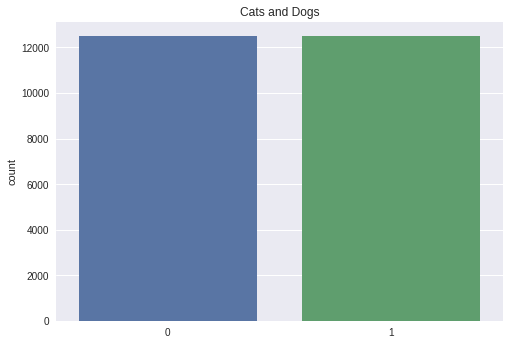

In [4]:
import seaborn as sns
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
sns.plt.title('Cats and Dogs')
sns.plt.show()

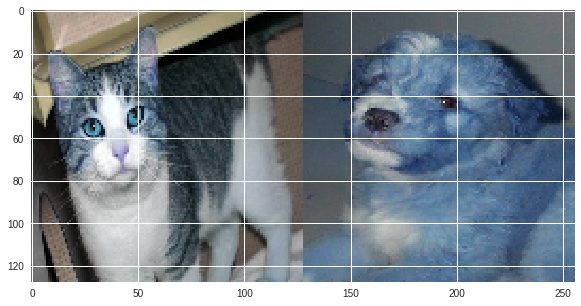

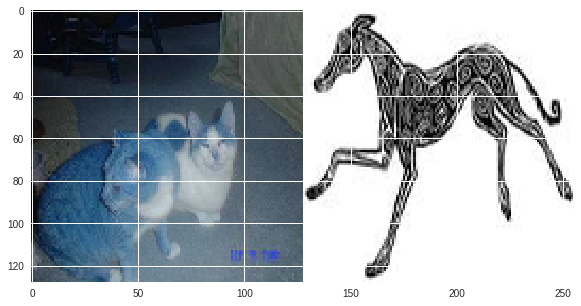

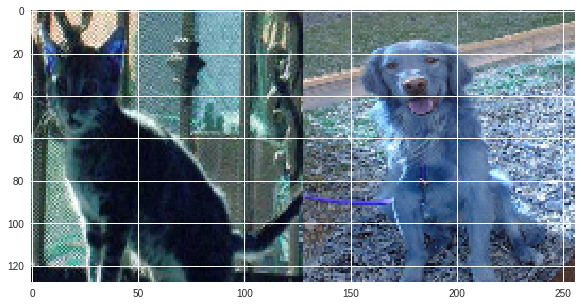

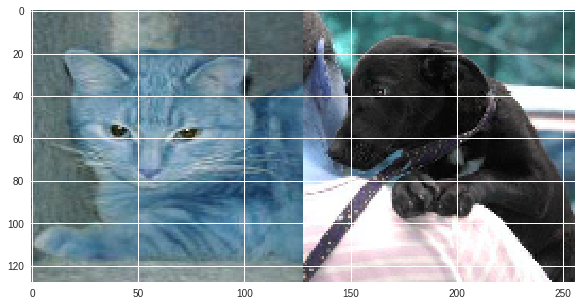

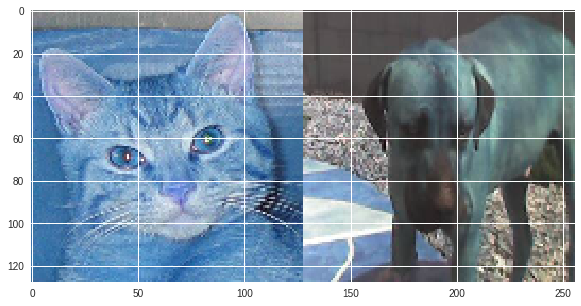

In [5]:
import matplotlib.pyplot as plt
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

In [6]:
train_set = train_images[:-5000]
train_labels = labels[:-5000]
valid_set = train_images[-5000:]
valid_labels = labels[-5000:]

In [7]:
#feature_det = cv2.FeatureDetector_create("SIFT")
#descr_ext = cv2.DescriptorExtractor_create("SIFT")
sift = cv2.xfeatures2d.SIFT_create()

def preProcessImages(image_paths):
    descriptors= []
    for image_path in tqdm(image_paths):
        im = read_image(image_path)
        gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kpts, des = sift.detectAndCompute(gray_im, None)
        descriptors.append(des)
    return descriptors

In [8]:
train_descriptors = preProcessImages(train_set)

100%|██████████| 20000/20000 [05:07<00:00, 65.02it/s]


In [14]:
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

flann_params = dict(algorithm = 1, trees = 5)
matcher = cv2.FlannBasedMatcher(flann_params, {})
bow_extract  =cv2.BOWImgDescriptorExtractor(sift,matcher)
bow_train = cv2.BOWKMeansTrainer(20)

def generateDic(bow_train, descriptors):
    print('Start adding descriptors')
    for des in tqdm(descriptors):
        bow_train.add(des)
    print('Start creating dictionary')
    voc = bow_train.cluster()
    joblib.dump(voc, "dictionary.pkl")
    return voc

def trainModle(voc, bow_extract, image_classes, image_paths):
    bow_extract.setVocabulary(voc)
    traindata = []
    print('Start generating features')
    for i,imagepath in enumerate(image_paths):
        featureset = getImagedata(sift,bow_extract,imagepath)
        traindata.extend(featureset)
        if i%1000 == 0: print('Feature Processed {} of all'.format(i))
    clf = LinearSVC()
    clf.fit(traindata, np.array(image_classes))
    joblib.dump(clf, "imagereco.pkl", compress=3)
    return clf

def getImagedata(sift,bow_extract,path):
    im = read_image(path)
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    featureset = bow_extract.compute(gray_im, sift.detect(gray_im))
    return featureset

In [ ]:
# def train(descriptors,image_classes,image_paths): 
#     flann_params = dict(algorithm = 1, trees = 5)
#     matcher = cv2.FlannBasedMatcher(flann_params, {})
#     bow_extract  =cv2.BOWImgDescriptorExtractor(sift,matcher)
#     bow_train = cv2.BOWKMeansTrainer(20)
#     print('Start adding descriptors')
#     for i,des in enumerate(descriptors):
#         bow_train.add(des)
#         if i%5000 == 0: print('added descriptors {} of all'.format(i))
#     #create dictionary   
#     print('Start creating dictionary')
#     voc = bow_train.cluster()
#     joblib.dump(voc, "dictionary.pkl")
#     bow_extract.setVocabulary(voc)
#     traindata = []
#     print('Start generating features')
#     for i,imagepath in enumerate(image_paths):
#         featureset = getImagedata(sift,bow_extract,imagepath)
#         traindata.extend(featureset)
#         if i%1000 == 0: print('Feature Processed {} of all'.format(i))
    
#     clf = LinearSVC()
#     clf.fit(traindata, np.array(image_classes))
    
#     joblib.dump((voc,clf), "imagereco.pkl", compress=3)
#     return clf
    
# def getImagedata(sift,bow_extract,path):
#     im = read_image(path)
#     gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#     featureset = bow_extract.compute(gray_im, sift.detect(im))
#     return featureset

In [ ]:
voc = generateDic(bow_train,train_descriptors)

100%|██████████| 20000/20000 [00:00<00:00, 830933.69it/s]

Start adding descriptors
Start creating dictionary


In [ ]:
#clf = train(train_descriptors, labels, train_images)
clf = trainModle(voc, bow_extract, train_labels, train_set)

In [ ]:
voc = joblib.load("dictionary.pkl")
clf = joblib.load("imagereco.pkl")

In [ ]:
from tqdm import tqdm  

flann_params = dict(algorithm = 1, trees = 5)     
matcher = cv2.FlannBasedMatcher(flann_params, {})
bow_extract  =cv2.BOWImgDescriptorExtractor(sift,matcher)
bow_extract.setVocabulary( voc )
testing_classes = test_images
imgPath=[]

type=[]
valid_pred = []
for test_imagepath in tqdm(valid_set):
    featureset = getImagedata(sift,bow_extract,test_imagepath)
    prediction = clf.predict(featureset)
    valid_pred.append(prediction)
    if prediction ==1:
        predictText = "DOG"
    elif prediction ==0:
        predictText = "CAT"
    type.append(predictText)


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(valid_labels,valid_pred)

In [ ]:
test_images =  [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR)]
#test_images =  test_images[:50]

In [ ]:
#def predict(voc,clf):
flann_params = dict(algorithm = 1, trees = 5)     
matcher = cv2.FlannBasedMatcher(flann_params, {})
bow_extract  =cv2.BOWImgDescriptorExtractor(sift,matcher)
bow_extract.setVocabulary( voc )

#testImageFolder = "../../../data/images/testimage/"
#testing_classes = os.listdir(testImageFolder)

testing_classes = test_images
imgPath=[]

    #for foldername in testing_classes:
        #dir = os.path.join(testImageFolder, foldername)
        #for root, dirs, files in os.walk(dir):
            #for file in files:
                #imgPath.append(dir+"/"+file)


In [ ]:
test_images[1]

In [ ]:
type=[]
for test_imagepath in test_images:
    featureset = getImagedata(sift,bow_extract,test_imagepath)
    prediction = clf.predict(featureset)
    if prediction ==1:
        predictText = "DOG"
    elif prediction ==0:
        predictText = "CAT"
    type.append(predictText)
type

In [ ]:
import matplotlib.pyplot as plt
# for test_imagepath in test_images:
#     img = read_image(test_imagepath)
#     plt.figure(figsize=(10,5))
#     plt.imshow(img)
#     plt.annotate('cat', xy=(2, 1), xytext=(10, 5))
#     plt.show()
for i in range(0,25):
    img = read_image(test_images[i])
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.annotate(type[i], xy=(2, 1),size= 25,color='#ee8d18', xytext=(10, 10))
    plt.show()

In [ ]:
a = test_images[1]
a = a.split('/')[1]
num = a.split('.')[0]
num

In [ ]:

with open('submission_file.csv','w') as f:
    f.write('id,label\n')        
with open('submission_file.csv','a') as f:
    for img in tqdm(test_images):
        temp = img.split('/')[1]
        img_num = temp.split('.')[0]
        featureset = getImagedata(sift,bow_extract,img)
        prediction = clf.predict(featureset)
        f.write('{},{}\n'.format(img_num,prediction[0]))